In [11]:
import pandas as pd
import bz2
import os
import json
import twitter_functions
import multiprocessing as mp
from time import time

In [12]:
path_to_timeline='../data/timelines/API/IDF-old/'
bzs = sorted([x for x in os.listdir(path_to_timeline) if x[-4:]=='.bz2'])

In [13]:
bzs

['timelines-0-0-0-20-5557c651-0954-4d18-bcbe-2eb8170f6e8a.json.bz2',
 'timelines-0-0-0-20-66031178-958f-4fa4-81bd-ce37b8358438.json.bz2',
 'timelines-0-0-0-20-6f851a44-3715-4ad2-aba9-d2a198cac956.json.bz2',
 'timelines-0-0-0-20-97d479f8-4a2a-42f4-b3a2-cd58f52858fd.json.bz2',
 'timelines-0-0-0-20-a88c4479-adb6-4702-ba43-30a2019952ba.json.bz2',
 'timelines-0-0-0-20-b8748dc3-a6e9-4fb0-b6da-a5e2fad65d31.json.bz2',
 'timelines-0-0-0-20-c00a35a6-260a-4868-bd17-9fb87697b270.json.bz2',
 'timelines-0-0-0-20-d284a58b-6174-4cc4-869d-278a326cbb99.json.bz2',
 'timelines-0-0-0-4-32261e05-3bce-40af-9e23-3e72486243eb.json.bz2',
 'timelines-0-0-1-20-165b2965-3c01-43f7-9184-9686a96e6545.json.bz2',
 'timelines-0-0-1-20-1d86c638-bda7-4f67-bfa2-d2de0ca5fd16.json.bz2',
 'timelines-0-0-1-20-595e6abc-c531-46ba-a172-fbc9e9c3cc43.json.bz2',
 'timelines-0-0-1-20-7849f82e-178e-401d-a927-2e1cc2c3f25a.json.bz2',
 'timelines-0-0-1-20-98f4e02a-a1a7-49cf-a7f3-04f3575bd186.json.bz2',
 'timelines-0-0-1-20-ac298670-4003-

In [14]:
bzs=bzs[:16]

In [15]:
# START POOL OF CPUS
try:
    n_cpu = int(os.getenv("SLURM_CPUS_PER_TASK"))
    print('INFER # CORES FROM PBS VARIABLE')
except:
    n_cpu = mp.cpu_count()
    print('USE DEFAULT # CORES')
    
pool  = mp.Pool(processes=n_cpu)
print("# PROCESSORS:", n_cpu, "\n")

print("Read Tweets ...")
start = time()

# COMPUTE LIST OF RESULTS
n_blocks= len(bzs)//n_cpu + len(bzs)%n_cpu
print(n_blocks)
results = [pool.apply_async(twitter_functions.get_tweets, args=(index_block,n_blocks)) for index_block in range(n_cpu)]
print(results)
tweets  = pd.concat([results[index_block].get() for index_block in range(n_cpu)]).reset_index(drop=True)
print('done')
#print(tweets)

pool.close()    
print("DONE IN", round(time() - start), "SEC")


USE DEFAULT # CORES
# PROCESSORS: 8 

Read Tweets ...
2
[<multiprocessing.pool.ApplyResult object at 0x000002C880AC4F60>, <multiprocessing.pool.ApplyResult object at 0x000002C85ADED438>, <multiprocessing.pool.ApplyResult object at 0x000002C85ADED400>, <multiprocessing.pool.ApplyResult object at 0x000002C85ADED320>, <multiprocessing.pool.ApplyResult object at 0x000002C85ADED240>, <multiprocessing.pool.ApplyResult object at 0x000002C85ADED160>, <multiprocessing.pool.ApplyResult object at 0x000002C84622DBA8>, <multiprocessing.pool.ApplyResult object at 0x000002C846243CF8>]
done
DONE IN 1417 SEC


In [16]:
tweets.head()

,id_str,user,full_text,created_at,lang
0,1246817876910243841,"{'id': 3387491127, 'id_str': '3387491127', 'na...",RT @mandinette77: En triant mes bouquins je to...,Sun Apr 05 15:12:01 +0000 2020,fr
1,1246797555117297664,"{'id': 3387491127, 'id_str': '3387491127', 'na...",RT @Ch_Richard20: Voila la nouvelle vidéo de l...,Sun Apr 05 13:51:16 +0000 2020,fr
2,1246797196126756864,"{'id': 3387491127, 'id_str': '3387491127', 'na...",@_Pat_Sim_ C’est gentil ça ☺️\nQuel accueil ! ...,Sun Apr 05 13:49:50 +0000 2020,fr
3,1246795386003558405,"{'id': 3387491127, 'id_str': '3387491127', 'na...",@StephaneAlbouy C’est dingue tous ces journali...,Sun Apr 05 13:42:39 +0000 2020,fr
4,1246550688236273664,"{'id': 3387491127, 'id_str': '3387491127', 'na...",@Manu_Lechypre • Propos anti-arabes : « c’est ...,Sat Apr 04 21:30:18 +0000 2020,fr


# Analysis

In [17]:
tweets['user_id'] = tweets['user'].apply(lambda x: x.get('id_str'))

In [18]:
tweets['full_text'] = tweets['full_text'].apply(lambda x: x.lower())

In [19]:
tweets[tweets['full_text'].str.contains('covid')]

,id_str,user,full_text,created_at,lang,user_id
36,1245618679972106247,"{'id': 3387491127, 'id_str': '3387491127', 'na...",@ferrerofr bonjour l’équipe @ferrerofr bravo p...,Thu Apr 02 07:46:50 +0000 2020,fr,3387491127
49,1244216462321037312,"{'id': 3387491127, 'id_str': '3387491127', 'na...",rt @hopitalbichat: [#covid_19] retour à la mai...,Sun Mar 29 10:54:55 +0000 2020,fr,3387491127
63,1243533638613991424,"{'id': 3387491127, 'id_str': '3387491127', 'na...",@lll_izi @larocheposayfr @avenefrance @cerave_...,Fri Mar 27 13:41:37 +0000 2020,fr,3387491127
91,1243273636422828034,"{'id': 3387491127, 'id_str': '3387491127', 'na...",@cath1karate2 oui ma petite catherine ..... c’...,Thu Mar 26 20:28:28 +0000 2020,fr,3387491127
111,1242915128519122946,"{'id': 3387491127, 'id_str': '3387491127', 'na...",jamais je n’aurais pensé devoir un jour accuei...,Wed Mar 25 20:43:53 +0000 2020,fr,3387491127
114,1242724748381036544,"{'id': 3387491127, 'id_str': '3387491127', 'na...",rt @le_gorafi: #direct dans un avis rendu publ...,Wed Mar 25 08:07:23 +0000 2020,fr,3387491127
118,1242380645097226243,"{'id': 3387491127, 'id_str': '3387491127', 'na...",rt @sagittariushh: #thread revue très (trèèès ...,Tue Mar 24 09:20:02 +0000 2020,fr,3387491127
121,1242177113643499527,"{'id': 3387491127, 'id_str': '3387491127', 'na...",rt @olivierveran: 🔴 #covidー19 | suivez en dire...,Mon Mar 23 19:51:17 +0000 2020,fr,3387491127
125,1241882512579837953,"{'id': 3387491127, 'id_str': '3387491127', 'na...",rt @livyreal: la fnac a mis une sélection de p...,Mon Mar 23 00:20:38 +0000 2020,fr,3387491127
133,1241474955524661249,"{'id': 3387491127, 'id_str': '3387491127', 'na...",rt @jmconstantin: premier sdra covid+ extubé à...,Sat Mar 21 21:21:09 +0000 2020,fr,3387491127


In [20]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
tweets['day'] = tweets['created_at'].dt.floor('d')

## Contains covid or symptoms

In [28]:
tweets=tweets[tweets['created_at'] > '2019-12-01']

In [35]:
tweets.loc[tweets['full_text'].str.contains('covid|corona|coronavirus'), 'covid'] = 1


In [88]:
symptoms_dict_fr = {'toux' : ['toux', 'tousse'],
                   'maux de gorge' : ['maux de gorge', 'mal de gorge', 'mal à la gorge'],
                   'fièvre' : ['fievre', 'fièvre', 'fiévre'],
                   'perte goût et odorat' : ['perte du goût', "perte de l'odorat", 'perte du gout'],
                   'engelures' : ['engelures'],
                   'symptômes' : ['symptome', 'symptôme'],
                   'difficultés respiratoires' : ['difficultés à respirer', 'difficultés respiratoires', 'difficulté à respirer']}

for symptom in symptoms_dict_fr.keys():
    tweets[symptom] = 0
    tweets.loc[tweets['full_text'].str.contains(('|').join(symptoms_dict_fr.get(symptom))), symptom] = 1
    tweets.loc[tweets[symptom]==1, 'has_symptom'] = 1

In [86]:
# symptoms_list_fr = ['gorge', 'toux', 'fièvre', 'difficultés respiratoires', 'tousse', "perte de l'odorat", "perte du goût", "engelures"]
# for symptom in symptoms_list_fr:
#     tweets[symptom]=0
#     tweets.loc[tweets['full_text'].str.contains('symptom'), 'symptom'] = 1
#     tweets.loc[tweets['full_text'].str.contains(symptom), symptom] = 1

## Graphs

In [39]:
len(tweets.loc[tweets['covid']==1])

15134

In [40]:
from matplotlib import pyplot as plt

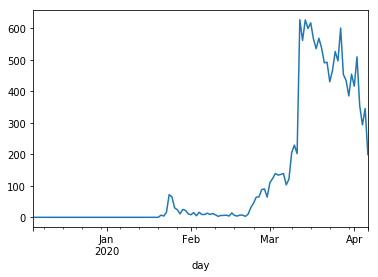

In [41]:
tweets[tweets['created_at'] > '2019-12-05'][['day', 'covid']].groupby('day').agg('sum')['covid'].plot()
plt.show()

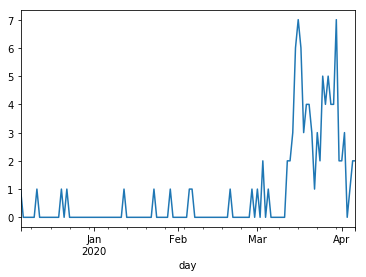

In [42]:
tweets[tweets['created_at'] > '2019-12-05'][['day', 'symptom']].groupby('day').agg('sum')['symptom'].plot()
plt.show()

C:\Users\naila\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



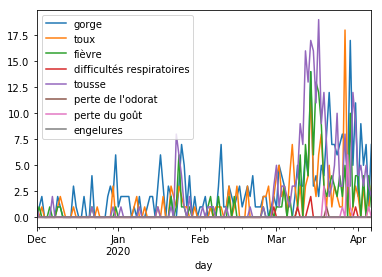

In [45]:
tweets[['day'] + symptoms_list_fr].groupby('day').agg('sum')[symptoms_list_fr].plot()
plt.show()

In [44]:
import plotly.figure_factory as ff
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools
py.init_notebook_mode(connected = True)

In [89]:
def plot_covid_evolution() :
    traces=[]
    df = tweets[['day','covid','has_symptom']].groupby('day').agg('sum')
    for value in ['covid','has_symptom']:
        traces.append(go.Scatter(x = df.index, 
                                 y = df[value].values,
                                mode = 'lines',
                                name = value))
    layout = go.Layout(title="Evolution of symptoms in Ile-de-France")
    fig = go.Figure(traces, layout)
    py.iplot(fig)
plot_covid_evolution()

In [80]:
def plot_symptoms_evolution() :
    traces=[]
    df = tweets[['day'] + list(symptoms_dict_fr.keys())].groupby('day').agg('sum')
    for symptom in symptoms_dict_fr.keys():
        traces.append(go.Scatter(x = df.index, 
                                 y = df[symptom].values,
                                mode = 'lines',
                                name = symptom))
    layout = go.Layout(title="Evolution of symptoms in Ile-de-France")
    fig = go.Figure(traces, layout)
    py.iplot(fig)
plot_symptoms_evolution()